# Text Classification using SciKit Learn

We will use the cleaned version of the covid tweets `TweetC_train.csv` and `TweetC_test.csv` to fit and test classic Machine Learning models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA, KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

import optuna
import xgboost as xgb
import seaborn as sns


In [2]:
train_data = pd.read_csv('Data/TweetC_train.csv')
test_data = pd.read_csv('Data/TweetC_test.csv')
print(f'Training obs: {train_data.shape[0]}, and testing obs: {test_data.shape[0]}')

Training obs: 41156, and testing obs: 3798


In [3]:
train_data.head()

,Corpus,label
0,advice talk neighbour family exchange phone nu...,4
1,coronavirus australia woolworth elderly disabl...,4
2,food stock panic food need stay calm stay safe,4
3,ready supermarket outbreak paranoid food stock...,0
4,news regionâs confirmed covid case came sulli...,4


In [4]:
# dropping indexes with nan

# training set
index_with_nan = train_data.index[train_data.isnull().any(axis=1)]
train_data.drop(index_with_nan,0, inplace=True)

# testing set
index_with_nan = test_data.index[test_data.isnull().any(axis=1)]
test_data.drop(index_with_nan,0, inplace=True)

In [5]:
# we have no nans left
pd.isna(train_data).sum(), pd.isna(test_data).sum()

(Corpus    0
 label     0
 dtype: int64, Corpus    0
 label     0
 dtype: int64)

In [6]:
# split text and labels

# text
text_train = train_data.iloc[:,0].copy().to_numpy()
text_test = test_data.iloc[:,0].copy().to_numpy()

# labels
y_train = train_data.iloc[:,1].copy().to_numpy()
y_test = test_data.iloc[:,1].copy().to_numpy()

y_train = y_train.astype('int')
y_test = y_test.astype('int')

We have already cleaned and removed all tweetws related signs that are not good for the analysis. We see that we have stayed only with the text and the sentiment class in an encoded version. 

`Extremely Negative`: 0

`Extremely Positive`: 1

`Negative`: 2

`Neutral`: 3

`Positive`: 4

## Apply vectorization with the `tf-idf` method provided from sklearn 

In [7]:
# assigning the class to tfidf
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')

# applying the vectorizer to the training data
X_train = tfidf.fit_transform(text_train).toarray()

X_test = tfidf.transform(text_test).toarray()

In [8]:
X_train.shape, X_test.shape

((41087, 9895), (3795, 9895))

We can see that after applying the vectorization provided from sklearn `tf-idf`, we have created a matrix with 13484 columns, representing each word present in the documents. This is a very sparse matrix for both the train and test documents. 

We will use the chi2 function from sklearn to get the most common words per category.

In [9]:
labels = {'Extremely Negative': 0,
          'Extremely Positive': 1,
          'Negative': 2,
          'Neutral': 3,
          'Positive': 4}

In [10]:
N = 2
for category, id in labels.items():
    features_chi2 = chi2(X_train, y_train == id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    # single words
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    # pair of words
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    # three words
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    print('\n**',category,'\n')
    print("  +Most correlated unigrams:\n   -{}".format('\n   -'.join(unigrams[-N:])))
    print("  +Most correlated bigrams:\n   -{}".format('\n   -'.join(bigrams[-N:])))
    print("  +Most correlated trigrams:\n   -{}".format('\n   -'.join(trigrams[-N:])))


** Extremely Negative 

  +Most correlated unigrams:
   -panic
   -crisis
  +Most correlated bigrams:
   -stop panic
   -panic buying
  +Most correlated trigrams:
   -people panic buying
   -stop panic buying

** Extremely Positive 

  +Most correlated unigrams:
   -best
   -great
  +Most correlated bigrams:
   -stay safe
   -hand sanitizer
  +Most correlated trigrams:
   -thank grocery store
   -health care worker

** Negative 

  +Most correlated unigrams:
   -hand
   -demand
  +Most correlated bigrams:
   -oil price
   -hand sanitizer
  +Most correlated trigrams:
   -consumer price march
   -oil price falling

** Neutral 

  +Most correlated unigrams:
   -like
   -panic
  +Most correlated bigrams:
   -panic buying
   -hand sanitizer
  +Most correlated trigrams:
   -retail store closure
   -shopping way covid

** Positive 

  +Most correlated unigrams:
   -hand
   -panic
  +Most correlated bigrams:
   -panic buying
   -hand sanitizer
  +Most correlated trigrams:
   -italy wuhan groc

## Preparing the data to fit to the different models

In [11]:
# applying an SVM model to it
svm_model = LinearSVC(C=0.1)
svm_model.fit(X_train, y_train)

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [12]:
svm_model.score(X_test, y_test)

0.525691699604743

In [13]:
y_pred = svm_model.predict(X_test)

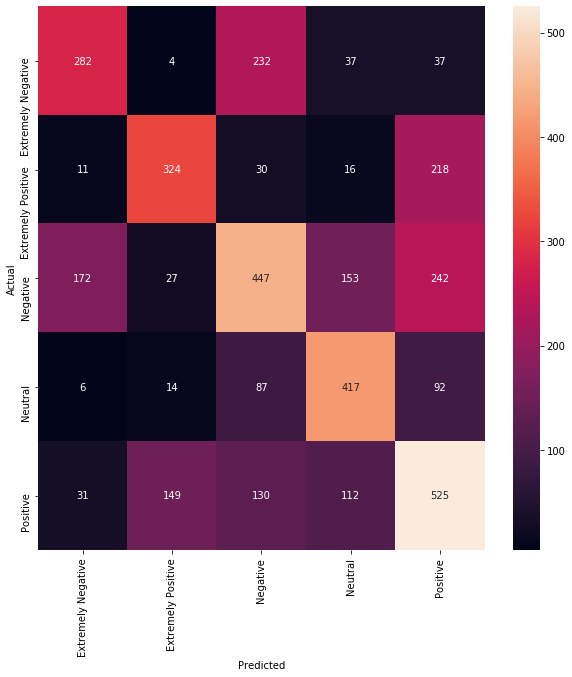

In [14]:
# generate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels.keys(), yticklabels=labels.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

We have seen that with a basic Linear SVM we get an accuracy of 0.52, we have set this accuracy with `n-grams` of one, two and three word combinations. 

## Hyper Parameter Opt. different models

## SVM HPO

In [15]:
# Fit the SVM
kfolds = KFold(n_splits=3, shuffle=True, random_state=0)
parameters = {'C': [1e-3, 1e-1, 1],
              'kernel': ['linear', 'rbf'],
              'gamma': [1e-4, 1e-2, 1]}

# choose SVM as the classifier
svc = SVC()
# make the grid search
svm = RandomizedSearchCV(svc, parameters, random_state=0, cv = kfolds, verbose=True, n_jobs=-1)
# fit the model
svm.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [ ]:
svm.score(X_test, y_test)

In [ ]:
svm.best_params_

## Logistic Regression

In [18]:
# simple lr
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.5293807641633729

hyper parameter tunning C

In [22]:
# optimizing its parameters
params = {'C' : [ 0.01, 0.1, 1, 10],
          'penalty': ['l1', 'l2'],
          'solver': ['newton-cg', "sag"]}

lr_model = RandomizedSearchCV(lr, params, cv=kfolds, n_jobs = -1)

lr_model.fit(X_train, y_train)
lr_model.best_params_

{'C': 1}

In [23]:
lr_model.score(X_test, y_test)

0.5293807641633729

## Xgboost + Optuna

In [24]:
# simple xgboost
xgboost = xgb.XGBClassifier()
xgboost.fit(X_train,  y_train)
xgboost.score(X_test, y_test)

KeyboardInterrupt: 

In [ ]:
# optimizing its parameters

def objective(trial):
    rf_opt = xgboost.set_params( learning_rate=trial.suggest_float("learning_rate", 0.01,0.2),
                   subsample = trial.suggest_categorical("subsample", [0.4,0.5,0.6,0.7,0.75,0.8,0.85]),
                   gamma = trial.suggest_float("gamma", 0, 0.4),
                   min_child_weight = trial.suggest_int("min_child_weight",1,10),
                   reg_alpha = trial.suggest_categorical("reg_alpha", [0, 0.001, 0.005, 0.01, 0.05]))
    
    scores = cross_val_score(rf_opt, X_train, y_train, 
                              scoring='accuracy', 
                              n_jobs=2,
                              cv=kfold)
    return scores.mean() 

np.random.seed(0)
rf_optuna = optuna.create_study(direction="maximize")
rf_optuna.optimize(objective, n_trials=20, n_jobs=4)

## Naive Bayes

Using gaussian naive bayes

In [19]:
# simple gaussian naive bayes model
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)

0.32042160737812914

## Random Forest Classifier

In [21]:
rforest = RandomForestClassifier(max_depth=2, random_state=0)
rforest.fit(X_train, y_train)
rforest.score(X_test, y_test)

0.25085638998682475

### Optimizing the HP

In [22]:
params = {'max_depth': [2,3,4,5,6],
          'min_samples_split': [2,4,6,8,10],
          'min_samples_leaf': [1,5,10,20,40]}
rf = RandomForestClassifier()

rf_model = RandomizedSearchCV(rforest, params, cv = 3)
rf_model.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=2,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=10,
                                                    n_jobs=None,
     

In [23]:
rf_model.score(X_test, y_test)

0.2658761528326746